# Pose Estimation

Human 2D pose estimation is about localizing anatomical keypoints or parts of each individual in the image.
![pose.png](imgs/pose.png)

## Detector based on pose estimation

You can substitute original detection method, such as Yolov5, FasterRCNN, with detector based on pose estimation. Openpose, a pose estimation method, can estimate the keypoints of people with accuracy and efficiency. If objects you want to detect is human type, you can consider this method

## ReID with pose information

With pose information, we can make our ReID feature more robust in tracking, and process ReID in a more systematic way.

### Pose-invariant reid feature
![](imgs/pose-reid.png)
> https://static.aminer.cn/upload/pdf/program/5a260c8617c44a4ba8a31cbf_0.pdf

### State-aware reid feature
![](imgs/state-reid.png)
![](imgs/state-feature.png)
> https://arxiv.org/pdf/1906.01357.pdf

# Show result of bodyposeworker

`BodyPoseWorker` integrates openpose with pretrained model. However, as the code is written in pure python, the inference time of model is quite long. The bottleneck is in postprocessing stage, especially in extracting keypoints, and grouping keypoints together.

## Import packages

In [4]:
# Modify sys paths for importing development module
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath(".")))

# Import necesary packages
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from app.utils.visualize import draw_bbox, draw_bodypose
from worker.pdetection.bodypose import BodyPoseDetector

%load_ext autoreload
%autoreload 2

## Read profile & Video

In [5]:
def read_profile(fname):
    """Return the profile result of dict type
    
    Format:
        fid,tid,xmin,ymin,xmax,ymax,keypoints...
    """
    profile = {}
    
    with open(fname, "r") as f:
        content = f.read()
        lines = [ line for line in content.split("\n") if len(line) > 0]
        
        # Read line by line
        for line in lines:
            fields = [ float(field) for field in line.split(",") ]
            if int(fields[0]) not in profile:
                profile[int(fields[0])] = []
            profile[int(fields[0])].append(fields)
    
        # Convert all result to numpy type
        for k in profile.keys():
            profile[k] = np.array(profile[k])

    return profile

In [6]:
# FILES
profile_name = "result/BodyPoseApp/group/gHO_sGR_c01_d19_d20_d21_mHO4_ch10.mp4.txt"
video_name = "result/BodyPoseApp/group/gHO_sGR_c01_d19_d20_d21_mHO4_ch10.mp4"

In [7]:
# Read in profile & video capture
profile = read_profile(profile_name)
cap = cv2.VideoCapture(video_name)

In [8]:
video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [10]:
import base64
import PIL

from io import BytesIO
from IPython.display import clear_output, Image, display, HTML

def ipython_img(a, fmt='jpeg'):
    f = BytesIO()
    img = PIL.Image.fromarray(a)
    img.save(f, fmt)
    return Image(data=f.getvalue())

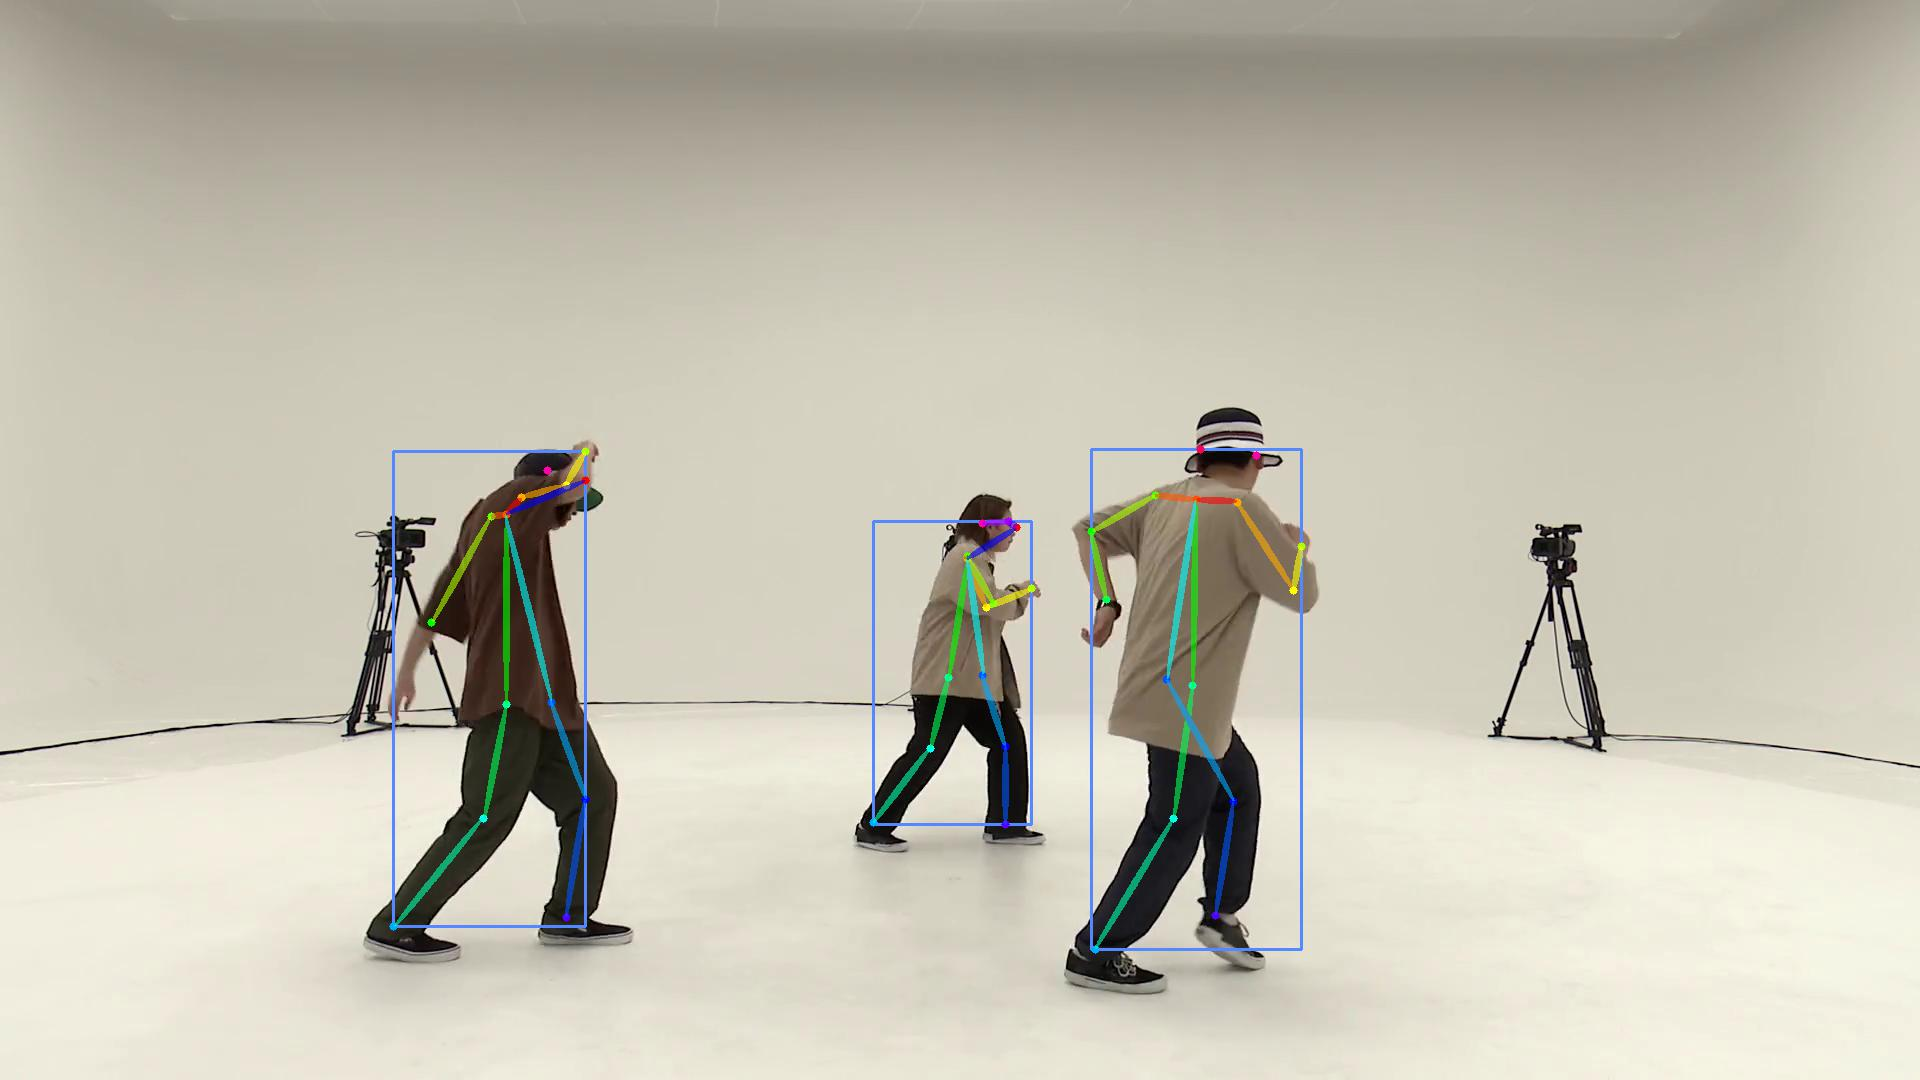

In [11]:
# Reset video capture reader to first frame
while True:
    try:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        
        for fid in range(video_length):
            # Read specific frame result
            people = profile[fid]
            bboxes = people[:, 2:2+4]
            keypoints = people[:, 6:]
            keypoints = keypoints.reshape(-1, 18, 3)

            # Read specific frame
            frame = cap.read()[1]
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Draw result
            for bbox, keypoint in zip(bboxes, keypoints):
                draw_bbox(frame, bbox)
                draw_bodypose(frame, keypoint)

            # Show result in jupyter
            img = ipython_img(frame)
            clear_output(wait=True)
            display(img)
            
    except KeyboardInterrupt:
        break